# Cluster modellen
Unsupervised learning

In [1]:
import pyodbc
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Database connectie

In [2]:
# database name
DB = {
    'servername': '(local)\\SQLEXPRESS',
    'database': 'DEDS_DataWarehouse'}

In [3]:
export_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')


# Create a cursor from the connection
export_cursor = export_conn.cursor()

# check if connection is successful, else throw an error
if export_conn:
    print("Connection with database is established")
else:
    print("Connection with database is not established")
    raise Exception("Connection with database is not established")

Connection with database is established


# Tabellen Inlezen
We hebben data nodig uit de volgende tabellen:
- Sales_branch

In [4]:
# Query om data uit de tabel te halen
query = "SELECT * FROM Sales_branch"

# Execute the query
result = export_cursor.execute(query)

# Fetch the data from the executed query
data_fetch = result.fetchall()

# converting to dataframe
sales_branch_columns = [column[0] for column in result.description]
sales_branch = pd.DataFrame.from_records(data_fetch, columns=sales_branch_columns)

# dropping columns that are not needed
sales_branch.drop(columns=['CURRENT_VALUE', 'LAST_UPDATED', 'SALES_BRANCH_SK', 'SALES_BRANCH_code', 'SALES_BRANCH_MAIN_ADDRESS_address', 'SALES_BRANCH_ADDRESS1_address', 'SALES_BRANCH_ADDRESS2_address'], inplace=True)

# display the data
sales_branch

,SALES_BRANCH_COUNTRY_CODE_country,SALES_BRANCH_REGION_region,SALES_BRANCH_CITY_city,SALES_BRANCH_POSTAL_ZONE_postal_zone
0,2,None,Hamburg,D-22529
1,2,None,München,D-81241
2,10,None,Kista,S-164 40
3,4,Alberta,Calgary,T2P 3Z0
4,4,Ontario,Toronto,M2M 4K8
5,3,Massachusetts,Boston,02133
6,3,Washington,Seattle,98139
7,3,California,Los Angeles,90072
8,3,Florida,Miami,33024
9,1,None,Lyon,F-69002


# Data Preprocessing
Null waarden vervangen en alles omzetten naar numerieke waarden

In [5]:
# filling the null values in the region column
sales_branch['SALES_BRANCH_REGION_region'].fillna('Unknown')

# converting the string columns to numerical values
sales_branch['SALES_BRANCH_REGION_region'] = sales_branch['SALES_BRANCH_REGION_region'].astype('category').cat.codes
sales_branch['SALES_BRANCH_CITY_city'] = sales_branch['SALES_BRANCH_CITY_city'].astype('category').cat.codes
sales_branch['SALES_BRANCH_POSTAL_ZONE_postal_zone'] = sales_branch['SALES_BRANCH_POSTAL_ZONE_postal_zone'].astype('category').cat.codes

sales_branch.head()

,SALES_BRANCH_COUNTRY_CODE_country,SALES_BRANCH_REGION_region,SALES_BRANCH_CITY_city,SALES_BRANCH_POSTAL_ZONE_postal_zone
0,2,-1,6,18
1,2,-1,16,19
2,10,-1,8,26
3,4,0,4,27
4,4,6,25,24


# KMeans
cluster model using KMeans

In [6]:
# Define a range of k values to try, from 2 to the number of data points -1 
ks = range(2, sales_branch.shape[0])

# Empty list to store the intra- and inter cluster distances
intra_distances = []
inter_distances = []
silhouette_scores = []

for k in ks:
    # Train een KMeans-model voor deze k
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(sales_branch)
    
    # Calculate the intra cluster distance as the sum of the distances of the samples to their closest cluster center. This is done by kmeans.inertia_
    intra_distance = kmeans.inertia_
    intra_distances.append(intra_distance)
    
    # Calculate the inter cluster distance as the mean distance between the cluster centers. this is done by pairwise_distances(kmeans.cluster_centers_)
    cluster_centers = kmeans.cluster_centers_
    inter_distance = np.mean(pairwise_distances(cluster_centers))
    inter_distances.append(inter_distance)
    
    # calculate the silhouette score
    silhouette_scores.append(silhouette_score(sales_branch, kmeans.labels_))

# Create a DataFrame with the results
k_df = pd.DataFrame({'k': ks, 'intra_distance': intra_distances, 'inter_distance': inter_distances, 'silhouette_score': silhouette_scores})
k_df

,k,intra_distance,inter_distance,silhouette_score
0,2,3735.917949,8.036639,0.271953
1,3,2704.090909,12.011624,0.299295
2,4,2217.416667,13.609120,0.253402
3,5,2021.708333,15.869598,0.193143
4,6,1595.877778,15.720016,0.262444
5,7,1285.261905,16.632143,0.294617
6,8,1245.142857,16.923007,0.290366
7,9,949.466667,17.646850,0.298411
8,10,798.000000,18.923925,0.312884
9,11,767.250000,17.058551,0.258763


## Plotting the intra- and inter-cluster distances

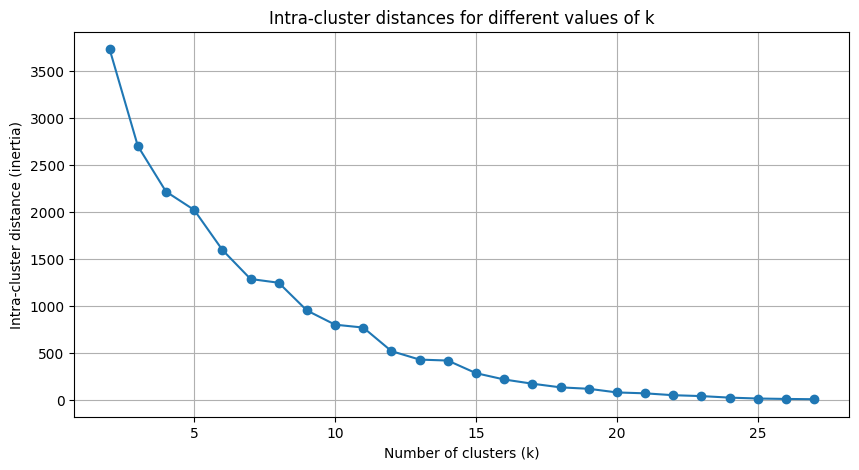

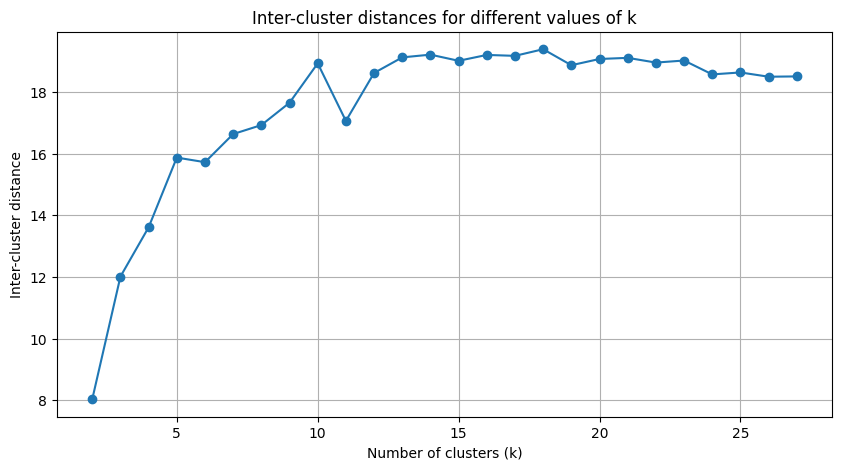

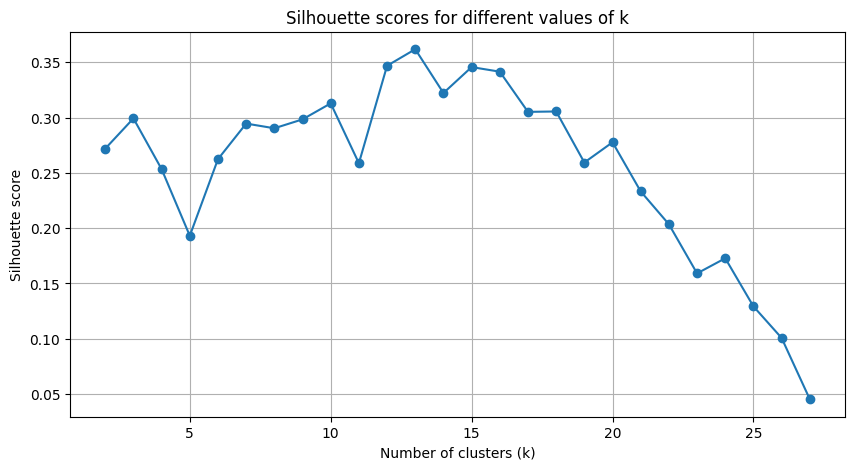

In [7]:
# Plotting the intra-cluster distances
plt.figure(figsize=(10, 5))
plt.plot(ks, intra_distances, marker='o')
plt.title('Intra-cluster distances for different values of k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Intra-cluster distance (inertia)')
plt.grid(True)
plt.show()

# Plotting the inter-cluster distances
plt.figure(figsize=(10, 5))
plt.plot(ks, inter_distances, marker='o')
plt.title('Inter-cluster distances for different values of k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inter-cluster distance')
plt.grid(True)
plt.show()

# plotting the silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(ks, silhouette_scores, marker='o')
plt.title('Silhouette scores for different values of k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.grid(True)
plt.show()

## Finding the optimal k

In [8]:
optimal_k = np.argmax(silhouette_scores) + 2

print(f"Optimal number of clusters based on silhouette score: k={optimal_k}")

Optimal number of clusters based on silhouette score: k=13


### Plotting the elbow

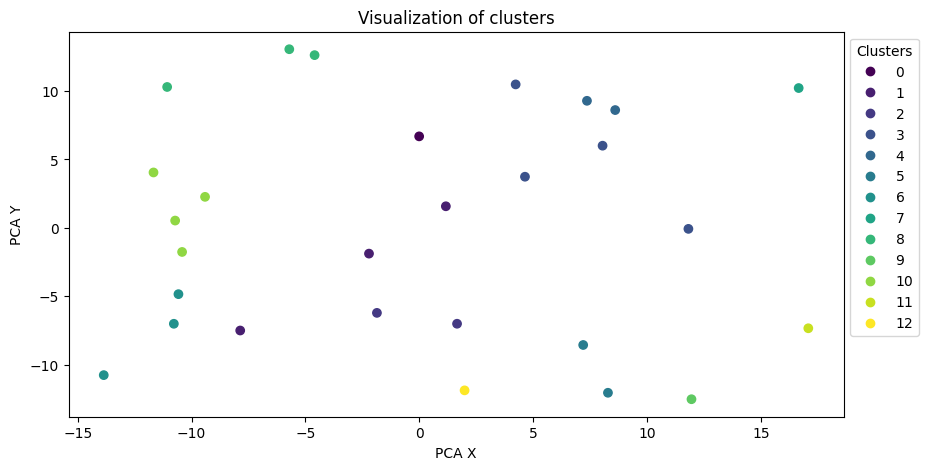

In [9]:
# Train a KMeans model with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_k)
kmeans_optimal.fit(sales_branch)

# Get the cluster assignments for each data point
cluster_assignments = kmeans_optimal.labels_

# Reduce the data to two dimensions using PCA
pca = PCA(n_components=2)
sales_branch_pca = pca.fit_transform(sales_branch)

# Create a scatter plot of the reduced data, colored by cluster assignment
plt.figure(figsize=(10, 5))
scatter = plt.scatter(sales_branch_pca[:, 0], sales_branch_pca[:, 1], c=cluster_assignments, cmap='viridis') # viridis is a color map which provides a smooth color transition
plt.title('Visualization of clusters')
# PCA is unsupervised, so we don't have labels. We can only label the axes
plt.xlabel('PCA X')
plt.ylabel('PCA Y')

# Create a legend
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper left", title="Clusters", bbox_to_anchor=(1, 1))
plt.show()